# A comparison of calibration of neural networks using SoftMax or Sigmoid outputs

When constructing a neural network to distinguish between two classifications (e.g. survived vs died), we have two options with neural networks:

1) Provide an output for each, with the probability of each being reported, e.g. died=84%, survived=16%. In this case out final output uses SoftMax to ensure that the probabilities add up to 1.0.

2) Provide an output for just one of the options, e.g. survived=16%. In this case the final output uses Sigmoid activation to scale the output between 0 and 1.

We would hope these two methods will give comparable results. While the final classification will be very similar, in this notebook we show that the reported probabilities are different, and that the sigmoid output provides a much better calibrated model.

## Load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn for processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.calibration import CalibrationDisplay

# pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F

## Download data if not previously downloaded

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)
    # Make all data 'float' type
    data = data.astype(float)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [3]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Load data

In [4]:
data = pd.read_csv('data/processed_data.csv')
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Convert to NumPy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Scale data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

## 1) SoftMax output

### Define neural net with SoftMax output

In [5]:
class Net(torch.nn.Module):
    
    def __init__(self, number_features, expansion=2):
        # Define layers
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(number_features, number_features * expansion)
        self.bn1 = torch.nn.BatchNorm1d(number_features * expansion)
        self.fc2 = torch.nn.Linear(number_features * expansion, number_features * expansion)
        self.bn2 = torch.nn.BatchNorm1d(number_features * expansion)
        self.fc3 = torch.nn.Linear(number_features * expansion, 2)
        
    def forward(self, x):
        # Define sequence of layers
        x = self.fc1(x) # Fully connected layer
        x = self.bn1(x) # Batch normalisation
        x = F.dropout(x, p=0.5) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # Fully connected layer
        x = self.bn2(x) # Batch normalisation
        x = F.dropout(x, p=0.5) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc3(x) # Fully connected layer
        x = F.softmax(x, dim=1) # Sigmoid output (0-1)
        
        return x

### Train network

In [6]:
# Define network
number_features = X_train_sc.shape[1]
net = Net(number_features)

# Set batch size (cases per batch - commonly 8-64)
batch_size = 16
# Epochs (number of times to pass over data)
num_epochs = 150
# Learning rate (how much each bacth updates the model)
learning_rate = 0.001
# Calculate number of batches
batch_no = len(X_train_sc) // batch_size

# Set up optimizer for classification
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train model by passing through the data the required number of epochs

training_progress = []
test_progress = []

for epoch in range(num_epochs):
    
    # Shuffle the training data
    X_train_sc, y_train = shuffle(X_train_sc, y_train)

    # Set net to training mode
    net.train()

    for i in range(batch_no):
        
        # Get X and y batch data
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train_sc[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))

        # These steps train the model: Forward + Backward + Optimize
        optimizer.zero_grad() # reset optimizer
        ypred_var = net(x_var) # predict y
        loss = criterion(ypred_var, y_var) # Calculate loss
        loss.backward() # Back propagate loss through network
        optimizer.step() # Update network to reduce loss

    # Set net to evaluation mode
    net.eval()

    test_var = Variable(torch.FloatTensor(X_train_sc))
    result = net(test_var)
    values, labels = torch.max(result, 1)
    y_pred_train = labels.data.numpy()
    accuracy_train = np.mean(y_pred_train == y_train)
    training_progress.append(accuracy_train)
    
    test_var = Variable(torch.FloatTensor(X_test_sc))
    result = net(test_var)
    values, labels = torch.max(result, 1)
    y_pred_test = labels.data.numpy()
    accuracy_test = np.mean(y_pred_test == y_test)
    test_progress.append(accuracy_test)

Show training

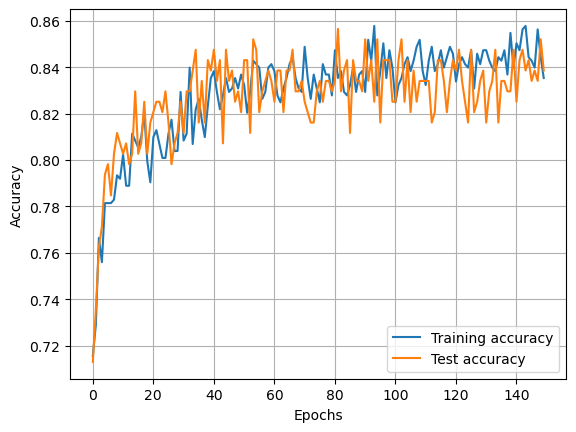

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
x = np.arange(num_epochs)
ax.plot(x, training_progress, label='Training accuracy')
ax.plot(x, test_progress, label='Test accuracy')
ax.grid()
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

### Show frequency of probabilities, and show model calibration

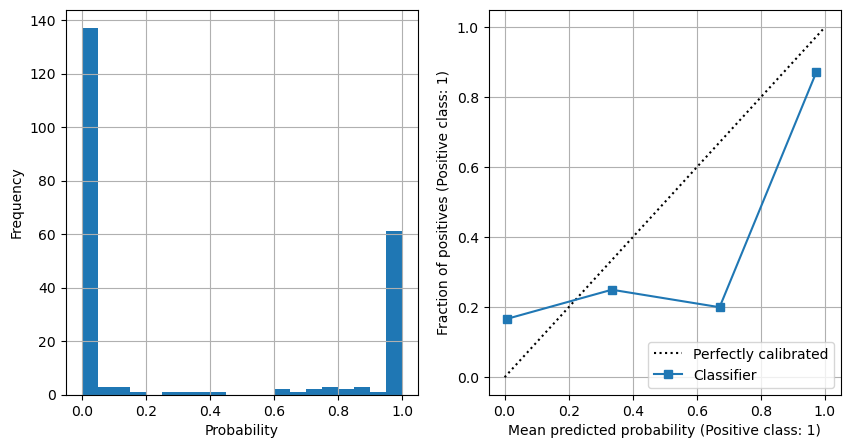

In [8]:
net.eval()
test_var = Variable(torch.FloatTensor(X_test_sc))
result = net(test_var)
softmax_probs = result[:,1].data.numpy()

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
x = np.arange(num_epochs)
ax1.hist(softmax_probs, bins=20)
ax1.grid()
ax1.set_xlabel('Probability')
ax1.set_ylabel('Frequency')

ax2 = fig.add_subplot(122)
disp1 = CalibrationDisplay.from_predictions(
    y_test, softmax_probs, ax=ax2, n_bins=4)
ax2.grid()

plt.show()

## 2) Sigmoid output

### Define neural net with Sigmoid output

In [9]:
class Net(torch.nn.Module):
    
    def __init__(self, number_features, expansion=2):
        # Define layers
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(number_features, number_features * expansion)
        self.bn1 = torch.nn.BatchNorm1d(number_features * expansion)
        self.fc2 = torch.nn.Linear(number_features * expansion, number_features * expansion)
        self.bn2 = torch.nn.BatchNorm1d(number_features * expansion)
        self.fc3 = torch.nn.Linear(number_features * expansion, 1)
        
    def forward(self, x):
        # Define sequence of layers
        x = self.fc1(x) # Fully connected layer
        x = self.bn1(x) # Batch normalisation
        x = F.dropout(x, p=0.5) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # Fully connected layer
        x = self.bn2(x) # Batch normalisation
        x = F.dropout(x, p=0.5) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc3(x) # Fully connected layer
        x = torch.sigmoid(x) # Sigmoid output (0-1)
        
        return x

### Train network

In [10]:
# Define network
number_features = X_train_sc.shape[1]
net = Net(number_features)

# Set batch size (cases per batch - commonly 8-64)
batch_size = 16
# Epochs (number of times to pass over data)
num_epochs = 150
# Learning rate (how much each bacth updates the model)
learning_rate = 0.001
# Calculate number of batches
batch_no = len(X_train_sc) // batch_size

# Set up optimizer for classification
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train model by passing through the data the required number of epochs

training_progress = []
test_progress = []

for epoch in range(num_epochs):

    # Shuffle training data
    X_train_sc, y_train = shuffle(X_train_sc, y_train)

    # Set net to training mode
    net.train()

    for i in range(batch_no):
        
        # Get X and y batch data
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train_sc[start:end]))
        y_var = Variable(torch.FloatTensor(y_train[start:end]))

        # These steps train the model: Forward + Backward + Optimize
        optimizer.zero_grad() # reset optimizer
        ypred_var = net(x_var) # predict y
        loss = criterion(ypred_var, y_var.reshape(-1,1)) # Calculate loss
        loss.backward() # Back propagate loss through network
        optimizer.step() # Update network to reduce loss

    # Set net to evaluation mode
    net.eval()

    test_var = Variable(torch.FloatTensor(X_train_sc))
    result = net(test_var)
    values = result.data.numpy().flatten()
    y_pred_train = values >= 0.5
    accuracy_train = np.mean(y_pred_train == y_train)
    training_progress.append(accuracy_train)
    
    test_var = Variable(torch.FloatTensor(X_test_sc))
    result = net(test_var)
    values = result.data.numpy().flatten()
    y_pred_test = values >= 0.5
    accuracy_test = np.mean(y_pred_test == y_test)
    test_progress.append(accuracy_test)

Show training

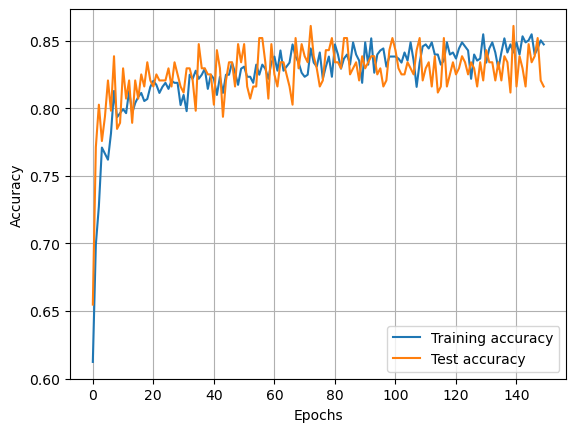

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
x = np.arange(num_epochs)
ax.plot(x, training_progress, label='Training accuracy')
ax.plot(x, test_progress, label='Test accuracy')
ax.grid()
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

### Show frequency of probabilities, and show model calibration

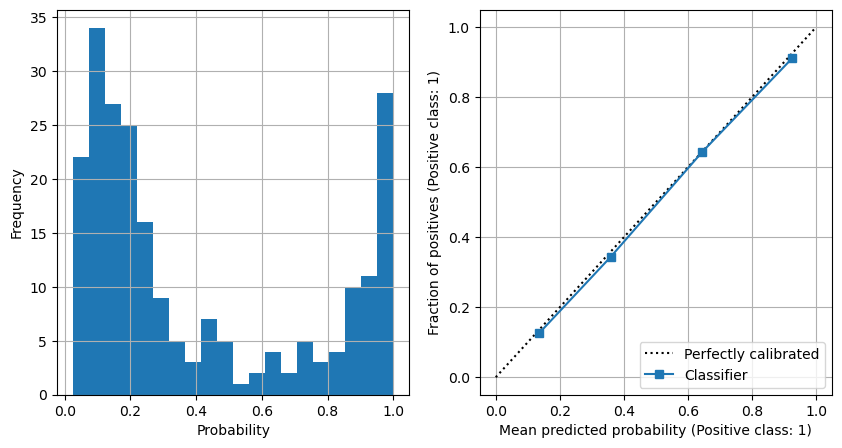

In [12]:
net.eval()
test_var = Variable(torch.FloatTensor(X_test_sc))
result = net(test_var)
sigmoid_probs = result.data.numpy().flatten()

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
x = np.arange(num_epochs)
ax1.hist(sigmoid_probs, bins=20)
ax1.grid()
ax1.set_xlabel('Probability')
ax1.set_ylabel('Frequency')

ax2 = fig.add_subplot(122)
disp1 = CalibrationDisplay.from_predictions(
    y_test, sigmoid_probs, ax=ax2, n_bins=4)
ax2.grid()

plt.show()

### Show a comparison of SoftMax and Sigmoid outputs

In [13]:
sigmoid_survive = sigmoid_probs >= 0.5
softmax_survive = softmax_probs >= 0.5
agreement = np.mean(sigmoid_survive == softmax_survive)
print (f'Percent agreement: {agreement * 100:0.1f}')

Percent agreement: 92.8


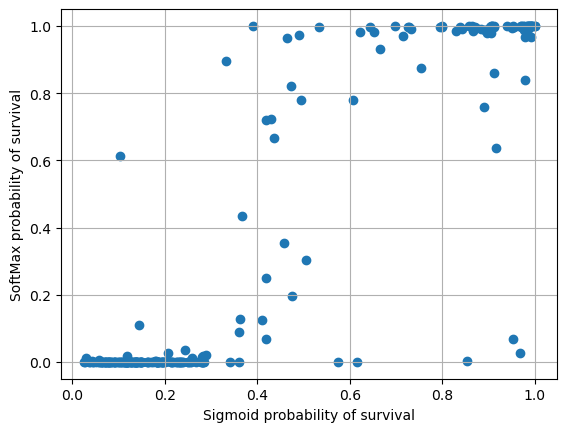

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(sigmoid_probs, softmax_probs)
ax.grid()
ax.set_xlabel('Sigmoid probability of survival')
ax.set_ylabel('SoftMax probability of survival')
plt.show()

## Observations

* Sigmoid output produces a well calibrated model
* SoftMax output polarises predicted survival probabilities towards 0 or 1, and has poor calibration